In [1]:
#Import required PyLibs
from pandas_datareader import data as web
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [2]:
#Get the stock tickers in the portfolio
assets = ['AMD','NFLX','AAPL','GOOG']

#Assign weights to each stock
weights = np.array([0.25,0.25,0.25,0.25])

#portfolio starting date
stockStartDate = '2016-01-01'

#portfolio ending date (today)
today = datetime.today().strftime('%Y-%m-%d')
today

'2021-11-08'

In [3]:
#Create a dataframe to store the adjusted close prices
df = pd.DataFrame()

for stock in assets:
    df[stock] = web.DataReader(stock,data_source='yahoo',start=stockStartDate,end=today)['Adj Close']

In [4]:
#Show df
df

,AMD,NFLX,AAPL,GOOG
Date,,,,
2016-01-04,2.770000,109.959999,24.251436,741.840027
2016-01-05,2.750000,107.660004,23.643715,742.580017
2016-01-06,2.510000,117.680000,23.181007,743.619995
2016-01-07,2.280000,114.559998,22.202669,726.390015
2016-01-08,2.140000,111.389999,22.320070,714.469971
...,...,...,...,...
2021-11-01,125.230003,681.169983,148.742920,2875.479980
2021-11-02,127.629997,677.719971,149.801376,2917.260010
2021-11-03,130.529999,688.289978,151.269241,2935.800049


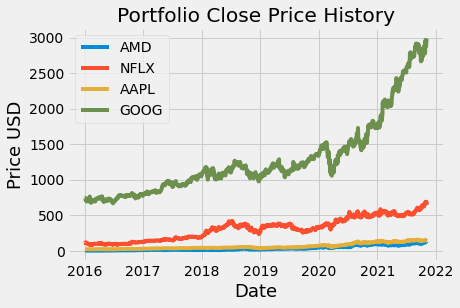

In [5]:
#Visualize data
title = 'Portfolio Close Price History'
my_stocks = df

#Create and plot the graph
for c in my_stocks.columns.values:
    plt.plot(my_stocks[c],label=c)
    
plt.title(title)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Price USD',fontsize=18)
plt.legend(my_stocks.columns.values,loc='upper left')
plt.show()

In [6]:
# show the Daily simple return
returns = df.pct_change()
returns

,AMD,NFLX,AAPL,GOOG
Date,,,,
2016-01-04,NaN,NaN,NaN,NaN
2016-01-05,-0.007220,-0.020917,-0.025059,0.000998
2016-01-06,-0.087273,0.093071,-0.019570,0.001400
2016-01-07,-0.091633,-0.026513,-0.042204,-0.023170
2016-01-08,-0.061403,-0.027671,0.005288,-0.016410
...,...,...,...,...
2021-11-01,0.041587,-0.013240,-0.005607,-0.030326
2021-11-02,0.019165,-0.005065,0.007116,0.014530
2021-11-03,0.022722,0.015596,0.009799,0.006355


In [7]:
# Create and show the annualized covariance matrix
#positive cov shows stock prices move toghether and vice versa
cov_matrix_annual = returns.cov()*252
cov_matrix_annual

,AMD,NFLX,AAPL,GOOG
AMD,0.383963,0.080380,0.073308,0.054801
NFLX,0.080380,0.156414,0.052598,0.051679
AAPL,0.073308,0.052598,0.086593,0.049199
GOOG,0.054801,0.051679,0.049199,0.067953


In [8]:
# Calculate the overal portfolio variance
port_variance = np.dot(weights.T,np.dot(cov_matrix_annual,weights))
port_variance

0.08867827769853444

In [9]:
# Calculate the portfolio volatility AKA standard deviation
port_volatility = np.sqrt(port_variance)
port_volatility

0.2977889818286339

In [10]:
# Calculate the annual portfolio return 
portfolio_simple_annual_return = np.sum(returns.mean()*weights)*252
portfolio_simple_annual_return

0.46596315247754666

In [11]:
# Show the expected annual return, volatility (risk), and variance
percent_var = str(round(port_variance,2)*100)+'%'
percent_vola = str(round(port_volatility,2)*100)+'%'
percent_ret = str(round(portfolio_simple_annual_return,2)*100)+'%'

print('Expected annual return: '+percent_ret)
print('Annual Volatility/ Risk: '+percent_vola)
print('Annual Variance: '+percent_var)

Expected annual return: 47.0%
Annual Volatility/ Risk: 30.0%
Annual Variance: 9.0%


In [12]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns 
from pypfopt import plotting

In [19]:
# Portfolio Optimization

# Calculate the expected returns and the annual sample covariance matrix for assets returns
mu = expected_returns.mean_historical_return(df)
S = risk_models.sample_cov(df)

# Optimize for max sharpe ratio
ef = EfficientFrontier(mu,S,weight_bounds=(None,None))
ef.add_constraint(lambda w: w[0]+w[1]+w[2]+w[3]==1)
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
print(cleaned_weights)
ef.portfolio_performance(verbose=True)

OrderedDict([('AMD', 0.41073), ('NFLX', 0.07594), ('AAPL', 0.41364), ('GOOG', 0.09969)])
Expected annual return: 59.6%
Annual volatility: 35.2%
Sharpe Ratio: 1.64


(0.595512508878145, 0.3517420170284735, 1.6361778832682286)

In [20]:
# Get the discrete allocation of each share per stock
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

latest_prices=get_latest_prices(df)
weights = cleaned_weights
da = DiscreteAllocation(weights,latest_prices,total_portfolio_value=5000)
allocation,leftover=da.lp_portfolio()
print('Discrete allocation: ',allocation)
print('Funds remaining: ${:.2f}'.format(leftover))

Discrete allocation:  {'AMD': 16, 'NFLX': 1, 'AAPL': 14}
Funds remaining: $54.92


InstantiationError: The objective function was changed after the initial optimization. Please create a new instance instead.

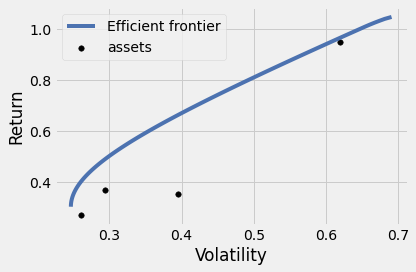

In [21]:
# Portfolio Optimization

# Calculate the expected returns and the annualized sample covariance matrix of asset returns
mu = expected_returns.mean_historical_return(df)
S = risk_models.sample_cov(df)

# Optimize for maximum sharpe ratio
ef = EfficientFrontier(mu,S,weight_bounds=(None,None))
ef.add_constraint(lambda w: w[0]+w[1]+w[2]+w[3] == 1)
plotting.plot_efficient_frontier(ef)
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights() 
print(cleaned_weights)
ef.portfolio_performance(verbose=True)